In [130]:
import pandas as pd
import numpy as np
import re
from itertools import groupby
from os import listdir, path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
## Conjunto de funções para unificar e padronizar os datasets

def formata_data_hora(mi):
    #troca / por - e remove 'UTC' das strings de hora
    data, hora = mi[0].replace('/', '-'), mi[1].replace(' UTC', '')
    if len(hora) == 4:  hora = hora[:2] + ':' + hora[2:]
    return data, hora

def ler_arquivo(arquivo):
    #lendo o arquivo em duas partes
    metadado = pd.read_csv(arquivo, encoding='latin_1', sep=';', decimal=',', nrows=8, header=None).set_index(0)
    dados = pd.read_csv(arquivo, skiprows=8, encoding='latin_1', sep=';', decimal=',').replace(-9999, np.nan)
    
    #removendo o : dos nomes dos metadados e normalizando as que variam com o tempo
    metadado.index = ['REGIÃO', 'UF', 'ESTAÇÃO', 'CODIGO (WMO)', 'LATITUDE', 'LONGITUDE', 'ALTITUDE', 'DATA DE FUNDAÇÃO (YYYY-MM-DD)']
    metadado = metadado.T.iloc[0]
    
    #acrescentando os dados de altitude, latitude e longitudo no dataframe (podem mudar de ano a ano)
    dados.assign(**{
        'ALTITUDE': metadado['ALTITUDE'],
        'LATITUDE': metadado['LATITUDE'],
        'LONGITUDE': metadado['LONGITUDE']
    })
    
    #normalizando nomes de colunas que mudam na planilha
    dados.rename({
        dados.columns[0]: 'Data',
        dados.columns[1]: 'Hora',
        dados.columns[6]: 'RADIACAO GLOBAL (KJ/m²)'
    }, axis='columns', inplace=True)
    
    #retornando o codigo da estaçao, dicionario com a regiao, uf e nome da estação, dataframe com todos os dados
    return metadado['CODIGO (WMO)'], metadado[['REGIÃO', 'UF', 'ESTAÇÃO']].to_dict(), dados.set_index(list(dados.columns[:2]))

def concat_years(code, file_list, output_dir):
    #faz a leitura de cada arquivo
    years = []
    for file in sorted(file_list):
        _, metadata, dataframe = ler_arquivo(file)
        years.append(dataframe)
    
    #concatena e arruma o index
    df = pd.concat(years, copy=False)
    df.index = df.index.map(formata_data_hora)
        
    #salva o arquivo concatenado e retorna os metadados
    name = f'{metadata["REGIÃO"]}_{metadata["UF"]}_{code}_{metadata["ESTAÇÃO"]}' #usa os metadados mais recentes
    df.sort_index().to_csv(f'{output_dir}/{name}.csv', sep=';', decimal=',', encoding='latin_1')

def padronize_data(inmet_dir, output_dir):
    #salvando o nome de todas as planilhas
    arquivos = []
    for folder in listdir(inmet_dir):
        c = f'{inmet_dir}/{folder}'
        if not path.isdir(c): continue
        if path.isdir(f'{c}/{folder}'): c = f'{c}/{folder}'
        arquivos += [f'{c}/{a}' for a in listdir(c) if a.endswith('.CSV')]
    print(f'Total de arquivos: {len(arquivos)}')
    
    #para cada codigo, concatena e adiciona o codigo e salva os metadados
    metadatas = []
    search_groups = lambda s: re.search('_([A-Z][0-9]{3})_', s).group(1)
    for k, grupo in groupby(sorted(arquivos, key=search_groups), search_groups):
        print(f'Codigo {k}...', end='')
        concat_years(k, grupo, output_dir)
        print('OK')

In [5]:
path_inmet = 'datasets/inmet'
path_output = 'datasets/agregados'
padronize_data(path_inmet, path_output)

NameError: name 'padronize_data' is not defined

In [118]:
## Conjunto de funções para usar os dados padronizados

def days_off(file):
    # ler arquivos padronizados e marca os dias que a estação estava off
    data = pd.read_csv(file, encoding='latin_1', sep=';', decimal=',', index_col = [0, 1]) \
                        .isna().apply(lambda row: all(row), axis = 1) \
                        .groupby(level=0).apply(lambda group: sum(group) == 24)
    data.name = file[:-4].split('/')[-1]
    return data

def all_days_off(path, group_by=None):
    #contabiliza a porcentagem de estações off no dia
    stations = pd.concat([days_off(path+file) for file in listdir(path)], axis=1).T
    
    if group_by == 'states':
        answer = stations.groupby(lambda x: x.split('_')[1]).apply(lambda x: x.mean())
    elif group_by == 'region':
        answer = stations.groupby(lambda x: x.split('_')[0]).apply(lambda x: x.mean())
    else:
        answer = stations
     
    answer = answer.reindex(columns=sorted(answer.columns))
    return answer
        

In [120]:
df = all_days_off('datasets/agregados/', group_by='region')

In [161]:
[0] + indexes.cumsum().to_list()[:-1]

[0,
 239,
 604,
 969,
 1334,
 1700,
 2065,
 2430,
 2795,
 3161,
 3526,
 3891,
 4256,
 4622,
 4987,
 5352,
 5717,
 6083,
 6448,
 6813,
 7178,
 7544]

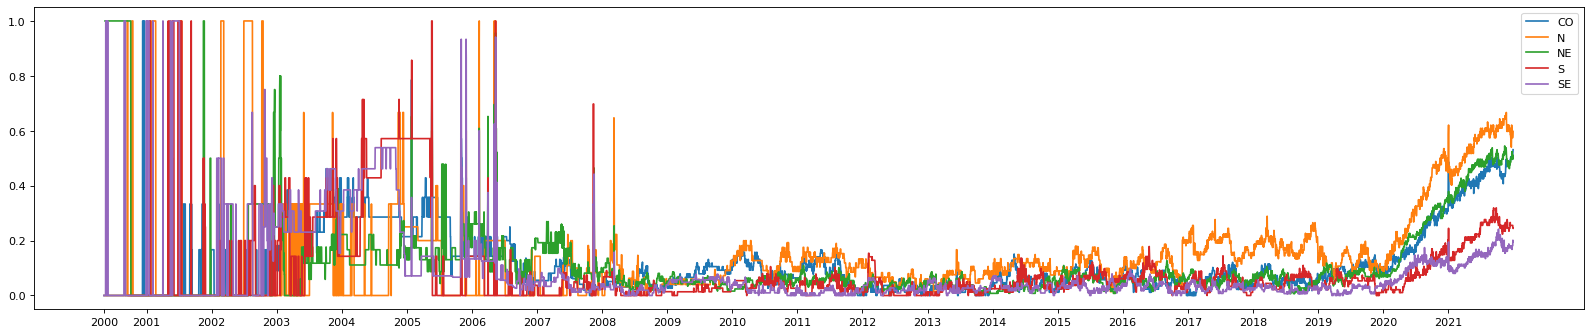

In [166]:
transformed = df.T

figure(figsize=(25, 5), dpi=80)
ax = plt.axes()

for r in transformed:
    region =transformed[r] 
    plt.plot(region.loc[region.first_valid_index():], label=r)
plt.legend(loc='best')

indexes = transformed.groupby(lambda x: x.split('-')[0]).size()
ax.set_xticks( [0] + indexes.cumsum().to_list()[:-1] )
ax.set_xticklabels(indexes.index)

plt.show()

In [6]:
#todo: adaptar para os novos formatos
p = path_inmet
def resumo(arquivo):
    metadado = pd.read_csv(arquivo, encoding='latin_1', sep=';', decimal=',', nrows=8, header=None)
    local = f'{metadado.iloc[0, 1]} -- {metadado.iloc[1, 1]} -- {metadado.iloc[3,1]} -- {metadado.iloc[2,1]}'
    
    dados = pd.read_csv(arquivo, skiprows=8, encoding='latin_1', sep=';', decimal=',').replace(-9999, np.nan)
    return dados.min().rename(local), dados.max().rename(local), (dados.isnull().sum(axis=0)/len(dados)*100).rename(local), dados.apply(lambda x: x.groupby(x.notna().cumsum()).cumcount().max()).rename(local)

def resumo_anual(ano):
    tabelas = {
        'min': [], #minimo de cada coluna
        'max': [], #maximo de cada coluna
        'porcentagem': [], #porcentagem de nulos em cada coluna
        'sequencia': []  #maior sequencia de nulos
    }
    
    d = f'{p}/{ano}/'
    if path.isdir(f'{d}{ano}'): d = f'{d}{ano}/'
        
    for file in listdir(d):
        minimo, maximo, porcentagem, sequencia = resumo(d+file)
        tabelas['min'].append(minimo)
        tabelas['max'].append(maximo)
        tabelas['porcentagem'].append(porcentagem)
        tabelas['sequencia'].append(sequencia)
    
    for k, v in tabelas.items():
        df = pd.DataFrame(v)
        df.columns = [f'{k.upper()} - {c}' for c in df.columns]
        tabelas[k] = df
        
    colunas = [v.columns for k, v in tabelas.items()]
    colunas = [j for i in zip(*colunas) for j in i]
    return pd.concat(tabelas.values(), axis=1).reindex(columns=colunas).sort_index()#

In [9]:
todos = {}
for ano in range(2000, 2022):
    print(f'Procesando ano {ano}...', end='')
    df = resumo_anual(ano)
    todos[ano] = df
    #df.to_csv(f'{ano}.csv', sep=';', decimal=',', encoding='latin_1')
    print('OK')

Procesando ano 2000...OK
Procesando ano 2001...OK
Procesando ano 2002...OK
Procesando ano 2003...OK
Procesando ano 2004...OK
Procesando ano 2005...OK
Procesando ano 2006...OK
Procesando ano 2007...OK
Procesando ano 2008...OK
Procesando ano 2009...OK
Procesando ano 2010...OK
Procesando ano 2011...OK
Procesando ano 2012...OK
Procesando ano 2013...OK
Procesando ano 2014...OK
Procesando ano 2015...OK
Procesando ano 2016...OK
Procesando ano 2017...OK
Procesando ano 2018...OK
Procesando ano 2019...OK
Procesando ano 2020...OK
Procesando ano 2021...OK


In [14]:
#filtrado = [(k, v[v.index.str.startswith(('S -- SC', 'SE -- SP'))]) for k, v in todos.items()]
pd.DataFrame([v['PORCENTAGEM - PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].rename(k) for k, v in todos.items() if not v.empty]).T.sort_index().applymap(lambda x: 'x' if x < 10 else '').to_csv('datasets/maior_10%.csv', sep=';', decimal=',', encoding='latin_1')